# Projet

In [20]:
# Evaluation du modele V2 (avec sortie modele) mot de passe avec &
from unidecode import unidecode


# Charger le modèle entraîné
if path.exists("/kaggle/working/models/password_rnn_1746462969.pt"):
    decoder = torch.load("/kaggle/working/models/password_rnn_1746462969.pt").to(device)
    decoder.eval()  # Mettre le modèle en mode évaluation
    print("✅ Modèle chargé avec succès !")
else:
    print("❌ Erreur : modèle introuvable.")
    exit()

# Charger les données de validation
try:
    val_file = unidecode(open("/kaggle/input/validation2/validation2.txt").read())
    val_file_len = len(val_file)
except FileNotFoundError:
    print("❌ Erreur : Le fichier validation2.txt est introuvable.")
    exit()

# Fonction pour obtenir un batch de validation
def validation_set():
    start_index = random.randint(0, val_file_len - chunk_len - 1)
    end_index = start_index + chunk_len + 1
    chunk = val_file[start_index:end_index]
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# ----------------------------------------------------------------------------------
# 1) utilitaires pour convertir indices ⇄ caractères
# ----------------------------------------------------------------------------------
all_characters = (
    "abcdefghijklmnopqrstuvwxyz"
    "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    "0123456789"
    "!@#$%^&*()-_=+[]{};:'\",.<>?/\\|`~ "   # mêmes caractères que pendant l'entraînement
)
n_characters = len(all_characters)

def idx_to_char(idx):
    return all_characters[idx]

def tensor_to_string(tensor):
    """Convertit un tensor d'indices en chaîne de caractères."""
    chars = [idx_to_char(i.item()) for i in tensor]
    return "".join(chars)


# Fonction d'évaluation
def evaluate_model(num_samples=500, return_samples=False, save_to_file=None):
    """
    - num_samples       : nombre de séquences tirées dans la validation
    - return_samples    : si True, renvoie la liste (pred, target)
    - save_to_file      : chemin d’un fichier .txt pour y écrire les prédictions
    """
    total_loss = 0
    correct = 0
    total = 0
    all_losses = []
    samples = []  # stocke les couples (prediction, ground‑truth)

    # ouvrir le fichier de sortie si demandé
    f_out = open(save_to_file, "w", encoding="utf‑8") if save_to_file else None

    with torch.no_grad():
        for _ in range(num_samples):
            inp, target = validation_set()
            hidden = decoder.init_hidden()
            loss = 0
            seq_len = inp.size(0)

            predicted_chars = []  # caractères générés pour CETTE séquence

            for c in range(seq_len):
                output, hidden = decoder(inp[c].unsqueeze(0), hidden)
                loss += criterion(output, target[c].unsqueeze(0))

                # indice prédit
                pred_idx = output.argmax(dim=1).item()
                predicted_chars.append(idx_to_char(pred_idx))

                # accuracy char‑par‑char
                correct += (pred_idx == target[c].item())
                total += 1

            loss = loss.item() / seq_len
            total_loss += loss
            all_losses.append(loss)

            # reconstruction texte
            pred_str   = "".join(predicted_chars)
            target_str = tensor_to_string(target)

            # mémorise ou écrit
            if return_samples:
                samples.append((pred_str, target_str))
            if f_out:
                #f_out.write(f"{pred_str}\t{target_str}\n")
                f_out.write(f"{target_str}\n")

    if f_out:
        f_out.close()

    avg_loss = total_loss / num_samples
    accuracy = correct / total * 100  # précision par caractère

    if return_samples:
        return avg_loss, accuracy, all_losses, samples
    else:
        return avg_loss, accuracy, all_losses

# ----------------------------------------------------------------------------------
# 3) appel de la fonction
# ----------------------------------------------------------------------------------
val_loss, val_accuracy, all_losses, preds = evaluate_model(
    num_samples=100_000,          # ou moins si vous ne voulez pas saturer l’output
    return_samples=True,         # renvoie la liste des (prediction, cible)
    save_to_file="predictionsAvecCaractere2.txt"  # optionnel : écrit tout dans ce fichier
)

print(f"\n📊 Résultats sur {len(preds)} échantillons :")
print(f"   - Validation Loss     : {val_loss:.4f}")
print(f"   - Validation Accuracy : {val_accuracy:.2f}%\n")

# aperçu des 20 premières prédictions
for i, (p, t) in enumerate(preds[:20], 1):
    print(f"{i:02d}. pred: {p}   |   target: {t}")

<ipython-input-20-699762d49faa>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder = torch.load("/kaggle/working/models/password_rnn_1746462969.pt").to(device)


✅ Modèle chargé avec succès !

📊 Résultats sur 100000 échantillons :
   - Validation Loss     : 3.7424
   - Validation Accuracy : 8.56%

01. pred: eabaarrr2rse   |   target: lynnadennis1
02. pred: noonta2nnnn!   |   target: phish2aenon2
03. pred: eer!22rrtitt   |   target: ney13afupapa
04. pred: knerr!!!!rr!   |   target: olearootaall
05. pred: oon!sr!raaae   |   target: buggerahjkhj
06. pred: 96roenen!r!!   |   target: 9aprivate196
07. pred: 11223rsserr!   |   target: 5383aruteade
08. pred: 12722reeee2e   |   target: 1988aclcc2ca
09. pred: r2eeeieteer!   |   target: 1blownsbca3m
10. pred: r!aeararre!!   |   target: 4bpcaleah989
11. pred: 0072detet!r!   |   target: 010ahahayaya
12. pred: er!!2!reeeee   |   target: exy89ashitho
13. pred: eraaer!raan!   |   target: amblerasmart
14. pred: ssonnnn!!a!!   |   target: proatonycruz
15. pred: ersn!s!nenen   |   target: erideraniki1
16. pred: enetertennrn   |   target: agsterboafuc
17. pred: !eter!!!!!!!   |   target: cube98arieya
18. pred: sne

Training on password dataset …
 5s] Epoch 500/3000 – train loss 2.8726
 11s] Epoch 1000/3000 – train loss 2.6333
 17s] Epoch 1500/3000 – train loss 2.7112
 23s] Epoch 2000/3000 – train loss 2.8741
 28s] Epoch 2500/3000 – train loss 2.9822
 34s] Epoch 3000/3000 – train loss 1.9742


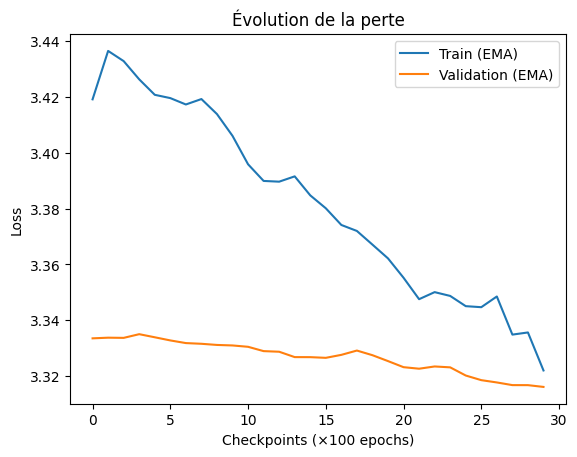


Exemples générés :
 • fikere
 • REEE
 • Z2
 • ganuntanr
 • 1cuckeeeiser
 • hevera
 • 2702736
 • &iner
 • 4177721
 • crerdran


In [19]:
# correction code François
# ==============================  CORRECTED PASSWORD‑RNN  ==================================
# - Alphabet unique (EOS = '&')  ➜ même mapping partout
# - Chunk de longueur variable   ➜ meilleure notion de fin
# - Boucle eval_loss indentée    ➜ calcul correct
# - Filtre des caractères hors alphabet
# - Gradient clipping
# ==============================================================================

!pip install -q unidecode

import string, random, time, math, torch, torch.nn as nn
import matplotlib.pyplot as plt
from unidecode import unidecode
from os import path, makedirs

# ----------------------- 1.  ENVIRONMENT --------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------- 2.  ALPHABET & HELPERS -------------------------------
end_char   = '&'
alphabet   = string.ascii_letters + string.digits + end_char
char2idx   = {c: i for i, c in enumerate(alphabet)}
idx2char   = {i: c for c, i in char2idx.items()}
n_chars    = len(alphabet)

def tensor_from_string(s: str) -> torch.Tensor:
    """Encode une chaîne → tensor[dtype long]"""
    return torch.tensor([char2idx[ch] for ch in s], dtype=torch.long, device=device)

# ----------------------- 3.  DATA ---------------------------------------------
# Datasets (adaptés à votre arborescence Kaggle)
train_file = unidecode(open("/kaggle/input/train3/train2_avec_caractereFinChaine.txt").read())
val_file   = unidecode(open("/kaggle/input/validation2/validation2.txt").read())

# Longueurs variables (5 – 12)
chunk_min, chunk_max = 5, 12
def random_chunk(text: str) -> str:
    """Sélectionne aléatoirement un slice ne contenant QUE des caractères autorisés."""
    while True:
        L     = random.randint(chunk_min, chunk_max)
        start = random.randint(0, len(text) - L - 1)
        chunk = text[start:start + L + 1]
        if all(ch in alphabet for ch in chunk):
            return chunk

def random_pair(text: str):
    chunk  = random_chunk(text)
    inp    = tensor_from_string(chunk[:-1])   #   ABCD  →  ABC
    target = tensor_from_string(chunk[1:])    #   ABCD  →   BCD
    return inp, target

# ----------------------- 4.  MODEL --------------------------------------------
class GRUModel(nn.Module):
    def __init__(self, vocab_size: int, hidden: int = 256, layers: int = 2):
        super().__init__()
        self.embed  = nn.Embedding(vocab_size, hidden)
        self.gru    = nn.GRU(hidden, hidden, layers)
        self.linear = nn.Linear(hidden, vocab_size)
        self.layers, self.hidden = layers, hidden

    def forward(self, x: torch.Tensor, h: torch.Tensor):
        x = self.embed(x.view(1, -1))           # (1, hidden)
        out, h = self.gru(x.view(1, 1, -1), h)  # (1, 1, hidden)
        out = self.linear(out.view(1, -1))      # (1, vocab)
        return out, h

    def init_hidden(self):
        return torch.zeros(self.layers, 1, self.hidden, device=device)

# ----------------------- 5.  HYPERPARAMS --------------------------------------
hidden_size, n_layers, lr, n_epochs = 256, 2, 0.005, 3000
model      = GRUModel(n_chars, hidden_size, n_layers).to(device)
optimizer   = torch.optim.Adam(model.parameters(), lr=lr)
criterion    = nn.CrossEntropyLoss()

# ----------------------- 6.  UTILS --------------------------------------------
def time_since(since): 
    s = time.time() - since
    m = math.floor(s / 60); s -= m * 60
    return f'{m}m {int(s)}s'

def ema(values, alpha=0.01):
    smoothed, avg = [], values[0]
    for v in values:
        avg = alpha * v + (1 - alpha) * avg
        smoothed.append(avg)
    return smoothed

# ----------------------- 7.  TRAIN / EVAL -------------------------------------
def train_step(inp, target):
    h = model.init_hidden()
    model.zero_grad()
    loss = 0

    for c in range(inp.size(0)):
        out, h = model(inp[c], h)
        loss  += criterion(out, target[c].unsqueeze(0))

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
    optimizer.step()
    return loss.item() / inp.size(0)

@torch.no_grad()
def eval_loss(samples=100):
    total = 0
    for _ in range(samples):
        inp, tgt = random_pair(val_file)
        h = model.init_hidden()
        loss = 0
        for c in range(inp.size(0)):
            out, h = model(inp[c], h)
            loss += criterion(out, tgt[c].unsqueeze(0))
        total += loss.item() / inp.size(0)
    return total / samples

@torch.no_grad()
def generate(prime='A', max_len=25, temperature=0.8):
    h = model.init_hidden()
    prime_t = tensor_from_string(prime)
    out_str = prime

    # Passe sur les caractères de départ (sauf le dernier)
    for p in range(len(prime_t) - 1):
        _, h = model(prime_t[p], h)
    inp = prime_t[-1]

    for _ in range(max_len):
        out, h = model(inp, h)
        probs  = torch.softmax(out.squeeze() / temperature, dim=0)
        idx    = torch.multinomial(probs, 1).item()
        ch     = idx2char[idx]
        if ch == end_char: break
        out_str += ch
        inp = torch.tensor([idx], device=device)
    return out_str

# ----------------------- 8.  MAIN LOOP ----------------------------------------
print("Training on password dataset …")
start_time = time.time()
train_losses, val_losses = [], []

for epoch in range(1, n_epochs + 1):
    loss = train_step(*random_pair(train_file))

    # Log/validation toutes les 100 itérations
    if epoch % 100 == 0:
        train_losses.append(loss)
        val_losses.append(eval_loss(50))

    if epoch % 500 == 0:
        print(f'[{time_since(start_time)}] Epoch {epoch}/{n_epochs} – train loss {loss:.4f}')

# ----------------------- 9.  PLOTS --------------------------------------------
sm_train = ema(train_losses)
sm_val   = ema(val_losses)

plt.plot(sm_train, label='Train (EMA)')
plt.plot(sm_val,   label='Validation (EMA)')
plt.xlabel('Checkpoints (×100 epochs)')
plt.ylabel('Loss')
plt.title('Évolution de la perte')
plt.legend()
plt.show()

# ----------------------- 10.  SAVE & SAMPLE -----------------------------------
if not path.exists("models"): makedirs("models")
torch.save(model, f"models/password_rnn_{int(time.time())}.pt")

print("\nExemples générés :")
for _ in range(10):
    rand_len = random.randint(5, 12)
    print(" •", generate(prime=random.choice(alphabet), max_len=rand_len, temperature=0.7))


In [18]:
# Evaluation du modele V2 (avec sortie modele) mot de passe avec &
from unidecode import unidecode


# Charger le modèle entraîné
if path.exists("/kaggle/working/models/password_rnn_1746459684.pt"):
    decoder = torch.load("/kaggle/working/models/password_rnn_1746459684.pt").to(device)
    decoder.eval()  # Mettre le modèle en mode évaluation
    print("✅ Modèle chargé avec succès !")
else:
    print("❌ Erreur : modèle introuvable.")
    exit()

# Charger les données de validation
try:
    val_file = unidecode(open("/kaggle/input/validation2/validation2.txt").read())
    val_file_len = len(val_file)
except FileNotFoundError:
    print("❌ Erreur : Le fichier validation2.txt est introuvable.")
    exit()

# Fonction pour obtenir un batch de validation
def validation_set():
    start_index = random.randint(0, val_file_len - chunk_len - 1)
    end_index = start_index + chunk_len + 1
    chunk = val_file[start_index:end_index]
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# ----------------------------------------------------------------------------------
# 1) utilitaires pour convertir indices ⇄ caractères
# ----------------------------------------------------------------------------------
all_characters = (
    "abcdefghijklmnopqrstuvwxyz"
    "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    "0123456789"
    "!@#$%^&*()-_=+[]{};:'\",.<>?/\\|`~ "   # mêmes caractères que pendant l'entraînement
)
n_characters = len(all_characters)

def idx_to_char(idx):
    return all_characters[idx]

def tensor_to_string(tensor):
    """Convertit un tensor d'indices en chaîne de caractères."""
    chars = [idx_to_char(i.item()) for i in tensor]
    return "".join(chars)


# Fonction d'évaluation
def evaluate_model(num_samples=500, return_samples=False, save_to_file=None):
    """
    - num_samples       : nombre de séquences tirées dans la validation
    - return_samples    : si True, renvoie la liste (pred, target)
    - save_to_file      : chemin d’un fichier .txt pour y écrire les prédictions
    """
    total_loss = 0
    correct = 0
    total = 0
    all_losses = []
    samples = []  # stocke les couples (prediction, ground‑truth)

    # ouvrir le fichier de sortie si demandé
    f_out = open(save_to_file, "w", encoding="utf‑8") if save_to_file else None

    with torch.no_grad():
        for _ in range(num_samples):
            inp, target = validation_set()
            hidden = decoder.init_hidden()
            loss = 0
            seq_len = inp.size(0)

            predicted_chars = []  # caractères générés pour CETTE séquence

            for c in range(seq_len):
                output, hidden = decoder(inp[c].unsqueeze(0), hidden)
                loss += criterion(output, target[c].unsqueeze(0))

                # indice prédit
                pred_idx = output.argmax(dim=1).item()
                predicted_chars.append(idx_to_char(pred_idx))

                # accuracy char‑par‑char
                correct += (pred_idx == target[c].item())
                total += 1

            loss = loss.item() / seq_len
            total_loss += loss
            all_losses.append(loss)

            # reconstruction texte
            pred_str   = "".join(predicted_chars)
            target_str = tensor_to_string(target)

            # mémorise ou écrit
            if return_samples:
                samples.append((pred_str, target_str))
            if f_out:
                #f_out.write(f"{pred_str}\t{target_str}\n")
                f_out.write(f"{target_str}\n")

    if f_out:
        f_out.close()

    avg_loss = total_loss / num_samples
    accuracy = correct / total * 100  # précision par caractère

    if return_samples:
        return avg_loss, accuracy, all_losses, samples
    else:
        return avg_loss, accuracy, all_losses

# ----------------------------------------------------------------------------------
# 3) appel de la fonction
# ----------------------------------------------------------------------------------
val_loss, val_accuracy, all_losses, preds = evaluate_model(
    num_samples=100_000,          # ou moins si vous ne voulez pas saturer l’output
    return_samples=True,         # renvoie la liste des (prediction, cible)
    save_to_file="predictionsAvecCaractere.txt"  # optionnel : écrit tout dans ce fichier
)

print(f"\n📊 Résultats sur {len(preds)} échantillons :")
print(f"   - Validation Loss     : {val_loss:.4f}")
print(f"   - Validation Accuracy : {val_accuracy:.2f}%\n")

# aperçu des 20 premières prédictions
for i, (p, t) in enumerate(preds[:20], 1):
    print(f"{i:02d}. pred: {p}   |   target: {t}")

<ipython-input-18-db68bc8b660c>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder = torch.load("/kaggle/working/models/password_rnn_1746459684.pt").to(device)


✅ Modèle chargé avec succès !

📊 Résultats sur 100000 échantillons :
   - Validation Loss     : 3.6723
   - Validation Accuracy : 6.81%

01. pred: nlnennaen!a!   |   target: beroapfunk84
02. pred: !!!!!ee!enen   |   target: uy8zmnewamoo
03. pred: lneen!ee!n!!   |   target: adriennea132
04. pred: 0!!!!!!LGGLG   |   target: 57595aPROPAN
05. pred: e!!ene!!ene!   |   target: 2awantclubsa
06. pred: eanenesne!ne   |   target: managyenyame
07. pred: !!!!a!!!nen!   |   target: 290jeffamitt
08. pred: 33m!!!!!!!3!   |   target: 2a261971a623
09. pred: an!!n!!ane!!   |   target: ox1a71monteg
10. pred: anees!!!!nea   |   target: andy21aeagle
11. pred: lennnemnnen!   |   target: moorbroada1l
12. pred: !nnnene!no!n   |   target: arabidcat2aa
13. pred: !!!!!!!!!!!!   |   target: 174983a61866
14. pred: neen!!!!ene!   |   target: kki555ahunte
15. pred: eene!!!!!enn   |   target: bun2000acarm
16. pred: 9lno!!!!!!en   |   target: aac2321atrus
17. pred: anee!!!!!n!!   |   target: ing007adont3
18. pred: ene

Entraînement sur le dataset de mots de passe...
 27s (1000 33%) 2.2211]
 55s (2000 66%) 2.8982]
 23s (3000 100%) 2.7413]


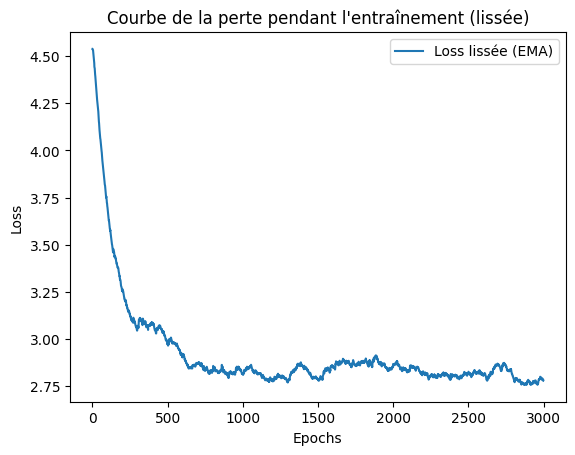

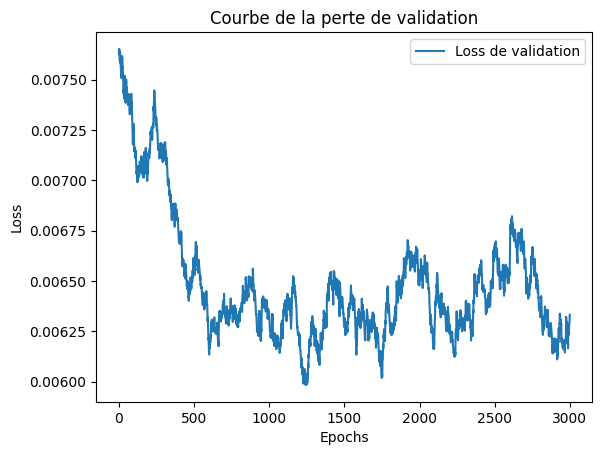

nGénération de mots de passe après entraînement :n
512
vde
hpernne
763
RIEVLEDLAEDLLEEHMEILO
88811
dine
wandmen29
q
h113Lfeskmheere5


In [6]:
!pip install unidecode

import unidecode
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import time, math
import matplotlib.pyplot as plt
from os import path, makedirs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_characters = string.ascii_letters + string.digits + string.punctuation
end_char = '&'
selected = string.ascii_letters + string.digits + end_char
n_characters = len(all_characters)
n_characters_selected = len(selected)

chunk_len = 12

hidden_size = 256
n_layers = 2
lr = 0.005
n_epochs = 3000


train_file = unidecode.unidecode(open("/kaggle/input/train3/train2_avec_caractereFinChaine.txt").read())
train_file_len = len(train_file)
val_file = unidecode.unidecode(open("/kaggle/input/validation2/validation2.txt").read())
val_file_len = len(val_file)

def random_chunk(file, file_len):
  start_index = random.randint(0, file_len - chunk_len - 1)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]

def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
    if string[c] not in selected:
      continue
    tensor[c] = selected.index(string[c])
  return tensor.to(device)

def random_training_set(file, file_len):
  chunk = random_chunk(file, file_len)
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.n_layers = n_layers

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size, device=device)


def train(inp, target):
  hidden = decoder.init_hidden()
  decoder.zero_grad()
  loss = 0
  seq_len = inp.size(0) # Récupérer la longueur du batch actuel
  for c in range(seq_len):
    output, hidden = decoder(inp[c], hidden)
    loss += criterion(output, target[c].unsqueeze(0))
  loss.backward()
  optimizer.step()
  train_losses.append(loss.item() / seq_len)
  return loss.item() / seq_len


def evaluate(prime_str='A', predict_len=25, temperature=0.8):
  if predict_len is None:
    predict_len = random.randint(5, 12)

  hidden = decoder.init_hidden()
  prime_input = char_tensor(prime_str)
  predicted = prime_str

  for p in range(len(prime_str) - 1):
    _, hidden = decoder(prime_input[p], hidden)
  inp = prime_input[-1]

  for _ in range(predict_len):
    output, hidden = decoder(inp, hidden)
    output_dist = torch.softmax(output.data.view(-1) / temperature, dim=0)
    top_i = torch.multinomial(output_dist[:len(selected)], 1)[0]
    predicted_char = selected[top_i]

    if predicted_char == '&':
      break

    predicted += predicted_char
    inp = torch.tensor([selected.index(predicted_char)]).to(device)

  return predicted


def time_since(since):
  s = time.time() - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

def exponential_moving_average(values, alpha=0.01):
  ema = []
  avg = values[0] # Initialisation
  for value in values:
    avg = alpha * value + (1 - alpha) * avg
    ema.append(avg)
  return ema

def evaluate_loss(n_samples=1000):
  total_loss = 0
  for _ in range(n_samples):
    inp, target = random_training_set(val_file, val_file_len)
    hidden = decoder.init_hidden()
    loss = 0
  for c in range(inp.size(0)):
    output, hidden = decoder(inp[c], hidden)
  loss += criterion(output, target[c].unsqueeze(0))
  total_loss += loss.item() / inp.size(0)
  return total_loss / n_samples

decoder = RNN(n_characters, hidden_size, n_characters, n_layers).to(device)
optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses = []
eval_losses = []
print("Entraînement sur le dataset de mots de passe...")

start = time.time()
for epoch in range(1, n_epochs + 1):
  loss = train(*random_training_set(train_file, train_file_len))
  with torch.no_grad():
    eval_loss = evaluate_loss(n_samples=50)
    eval_losses.append(eval_loss)
  if epoch % 1000 == 0:
    print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

smoothed_train_losses = exponential_moving_average(train_losses, alpha=0.01)
smoothed_eval_losses = exponential_moving_average(eval_losses, alpha=0.01)

plt.plot(smoothed_train_losses, label='Loss lissée (EMA)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de la perte pendant l\'entraînement (lissée)')
plt.legend()
plt.show()

plt.plot(smoothed_eval_losses, label='Loss de validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de la perte de validation')
plt.legend()
plt.show()

# save

if not path.exists("models"):
  makedirs("models")
torch.save(decoder, f"models/password_rnn_{int(time.time())}.pt")

print("nGénération de mots de passe après entraînement :n")
for _ in range(10):
  print(evaluate(prime_str=random.choice(selected), temperature=0.7))

In [5]:
# Evaluation du modele V2 (avec sortie modele)

# Charger le modèle entraîné
if path.exists("/kaggle/working/password_lstm_attention.pt"):
    decoder = torch.load("/kaggle/working/password_lstm_attention.pt").to(device)
    decoder.eval()  # Mettre le modèle en mode évaluation
    print("✅ Modèle chargé avec succès !")
else:
    print("❌ Erreur : modèle introuvable.")
    exit()

# Charger les données de validation
try:
    val_file = unidecode(open("/kaggle/input/validation2/validation2.txt").read())
    val_file_len = len(val_file)
except FileNotFoundError:
    print("❌ Erreur : Le fichier validation2.txt est introuvable.")
    exit()

# Fonction pour obtenir un batch de validation
def validation_set():
    start_index = random.randint(0, val_file_len - chunk_len - 1)
    end_index = start_index + chunk_len + 1
    chunk = val_file[start_index:end_index]
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# ----------------------------------------------------------------------------------
# 1) utilitaires pour convertir indices ⇄ caractères
# ----------------------------------------------------------------------------------
all_characters = (
    "abcdefghijklmnopqrstuvwxyz"
    "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    "0123456789"
    "!@#$%^&*()-_=+[]{};:'\",.<>?/\\|`~ "   # mêmes caractères que pendant l'entraînement
)
n_characters = len(all_characters)

def idx_to_char(idx):
    return all_characters[idx]

def tensor_to_string(tensor):
    """Convertit un tensor d'indices en chaîne de caractères."""
    chars = [idx_to_char(i.item()) for i in tensor]
    return "".join(chars)


# Fonction d'évaluation
def evaluate_model(num_samples=500, return_samples=False, save_to_file=None):
    """
    - num_samples       : nombre de séquences tirées dans la validation
    - return_samples    : si True, renvoie la liste (pred, target)
    - save_to_file      : chemin d’un fichier .txt pour y écrire les prédictions
    """
    total_loss = 0
    correct = 0
    total = 0
    all_losses = []
    samples = []  # stocke les couples (prediction, ground‑truth)

    # ouvrir le fichier de sortie si demandé
    f_out = open(save_to_file, "w", encoding="utf‑8") if save_to_file else None

    with torch.no_grad():
        for _ in range(num_samples):
            inp, target = validation_set()
            hidden = decoder.init_hidden()
            loss = 0
            seq_len = inp.size(0)

            predicted_chars = []  # caractères générés pour CETTE séquence

            for c in range(seq_len):
                output, hidden = decoder(inp[c].unsqueeze(0), hidden)
                loss += criterion(output, target[c].unsqueeze(0))

                # indice prédit
                pred_idx = output.argmax(dim=1).item()
                predicted_chars.append(idx_to_char(pred_idx))

                # accuracy char‑par‑char
                correct += (pred_idx == target[c].item())
                total += 1

            loss = loss.item() / seq_len
            total_loss += loss
            all_losses.append(loss)

            # reconstruction texte
            pred_str   = "".join(predicted_chars)
            target_str = tensor_to_string(target)

            # mémorise ou écrit
            if return_samples:
                samples.append((pred_str, target_str))
            if f_out:
                #f_out.write(f"{pred_str}\t{target_str}\n")
                f_out.write(f"{target_str}\n")

    if f_out:
        f_out.close()

    avg_loss = total_loss / num_samples
    accuracy = correct / total * 100  # précision par caractère

    if return_samples:
        return avg_loss, accuracy, all_losses, samples
    else:
        return avg_loss, accuracy, all_losses

# ----------------------------------------------------------------------------------
# 3) appel de la fonction
# ----------------------------------------------------------------------------------
val_loss, val_accuracy, all_losses, preds = evaluate_model(
    num_samples=20_000,          # ou moins si vous ne voulez pas saturer l’output
    return_samples=True,         # renvoie la liste des (prediction, cible)
    save_to_file="predictions.txt"  # optionnel : écrit tout dans ce fichier
)

print(f"\n📊 Résultats sur {len(preds)} échantillons :")
print(f"   - Validation Loss     : {val_loss:.4f}")
print(f"   - Validation Accuracy : {val_accuracy:.2f}%\n")

# aperçu des 20 premières prédictions
for i, (p, t) in enumerate(preds[:20], 1):
    print(f"{i:02d}. pred: {p}   |   target: {t}")

<ipython-input-5-84b247bb891f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder = torch.load("/kaggle/working/password_lstm_attention.pt").to(device)


✅ Modèle chargé avec succès !

📊 Résultats sur 20000 échantillons :
   - Validation Loss     : 3.3613
   - Validation Accuracy : 17.35%

01. pred: aaaaaaaaaaaa   |   target: aahsitesacja
02. pred: aaaaaaaaaaaa   |   target: 1acspartan05
03. pred: aaaaaaaaaaaa   |   target: ewee1af4fhel
04. pred: aaaaaaaaaaaa   |   target: orko1999aulo
05. pred: aaaaaaaaaaaa   |   target: afour1111ac8
06. pred: aaaaaaaaaaaa   |   target: 4abobsvala69
07. pred: aaaaaaaaaaaa   |   target: demerlliusag
08. pred: aaaaaaaaaaaa   |   target: 123amarch292
09. pred: aaaaaaaaaaaa   |   target: be1179abarbe
10. pred: aaaaaaaaaaaa   |   target: hachinoheabo
11. pred: aaaaaaaaaaaa   |   target: latortaabamb
12. pred: aaaaaaaaaaaa   |   target: afindsexamed
13. pred: aaaaaaaaaaaa   |   target: 72a194400ama
14. pred: aaaaaaaaaaaa   |   target: pectre170age
15. pred: aaaaaaaaaaaa   |   target: orola2a62206
16. pred: aaaaaaaaaaaa   |   target: a83594abiff1
17. pred: aaaaaaaaaaaa   |   target: trell1aboney
18. pred: aaa

In [3]:
# dernir code
# Installer unidecode si nécessaire
!pip install unidecode

import string
import random
import torch
import torch.nn as nn
import time, math
import matplotlib.pyplot as plt
from os import path, makedirs
from unidecode import unidecode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensembles des caractères pour les mots de passe
all_characters = string.ascii_letters + string.digits + string.punctuation
selected = string.ascii_letters + string.digits + string.punctuation
not_selected = string.whitespace
n_characters = len(all_characters)

chunk_len = 12
hidden_size = 256
n_layers = 2
lr = 0.005
n_epochs = 3000

# Chargement des données
file = unidecode(open("/kaggle/input/train2/train2.txt").read())
file_len = len(file)

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len - 1)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        if string[c] in not_selected:
            continue
        tensor[c] = selected.index(string[c])
    return tensor.to(device)

def random_training_set():
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# LSTM bidirectionnel avec Attention corrigé
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super(BiLSTMWithAttention, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, bidirectional=True, batch_first=True)

        # Correction : attention adaptée à un LSTM bidirectionnel
        self.attn = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, -1, hidden_size)
        output, (hn, cn) = self.lstm(x, hidden)

        # Mécanisme d'attention corrigé
        attn_weights = torch.softmax(self.attn(output.squeeze(0)), dim=1)
        attn_output = output.squeeze(0) * attn_weights  # Application de l'attention
        output = self.fc(attn_output)

        return output, (hn, cn)

    def init_hidden(self):
        return (torch.zeros(n_layers * 2, 1, hidden_size, device=device),
                torch.zeros(n_layers * 2, 1, hidden_size, device=device))

# Initialisation du modèle
decoder = BiLSTMWithAttention(n_characters, hidden_size, n_characters, n_layers).to(device)
optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []  # Stockage des pertes

# Fonction d'entraînement
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    seq_len = inp.size(0)

    for c in range(seq_len):
        output, hidden = decoder(inp[c].unsqueeze(0), hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    optimizer.step()

    all_losses.append(loss.item() / seq_len)
    return loss.item() / seq_len

# Fonction de génération de mots de passe
def evaluate(prime_str='A', predict_len=None, temperature=0.8):
    if predict_len is None:
        predict_len = random.randint(5, 12)

    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p].unsqueeze(0), hidden)
    inp = prime_input[-1]

    for _ in range(predict_len):
        output, hidden = decoder(inp.unsqueeze(0), hidden)
        output_dist = torch.softmax(output.view(-1) / temperature, dim=0)
        top_i = torch.multinomial(output_dist[:len(selected)], 1)[0]
        predicted_char = selected[top_i]
        predicted += predicted_char
        inp = torch.tensor([top_i], dtype=torch.long).to(device)

    return predicted

# Fonction pour mesurer le temps écoulé
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Lissage exponentiel des pertes
def exponential_moving_average(values, alpha=0.01):
    ema = []
    avg = values[0]
    for value in values:
        avg = alpha * value + (1 - alpha) * avg
        ema.append(avg)
    return ema

# Lancement de l'entraînement
print("Entraînement sur le dataset de mots de passe...")
start = time.time()

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())
    if epoch % 1000 == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

# Affichage de la courbe de perte
smoothed_losses = exponential_moving_average(all_losses, alpha=0.01)
plt.plot(smoothed_losses, label='Loss lissée (EMA)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de la perte pendant l\'entraînement (lissée)')
plt.legend()
plt.show()

# Sauvegarde du modèle
if not path.exists("models"):
    makedirs("models")
torch.save(decoder, "/kaggle/working/password_lstm_attention.pt")

# Génération de mots de passe après entraînement
print("\nGénération de mots de passe après entraînement :\n")
for _ in range(10):
    random_length = random.randint(5, 12)
    print(evaluate(prime_str=random.choice(selected), predict_len=random_length, temperature=0.7))

^C
ERROR: Operation cancelled by user
Entraînement sur le dataset de mots de passe...


KeyboardInterrupt: 

✅ Modèle chargé avec succès !


<ipython-input-2-cc4bccdf03cd>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder = torch.load("/kaggle/working/password_lstm_attention.pt").to(device)



📊 Résultats de la validation sur 100000 échantillons :
   - Validation Loss : 3.3572
   - Validation Accuracy : 6.40%


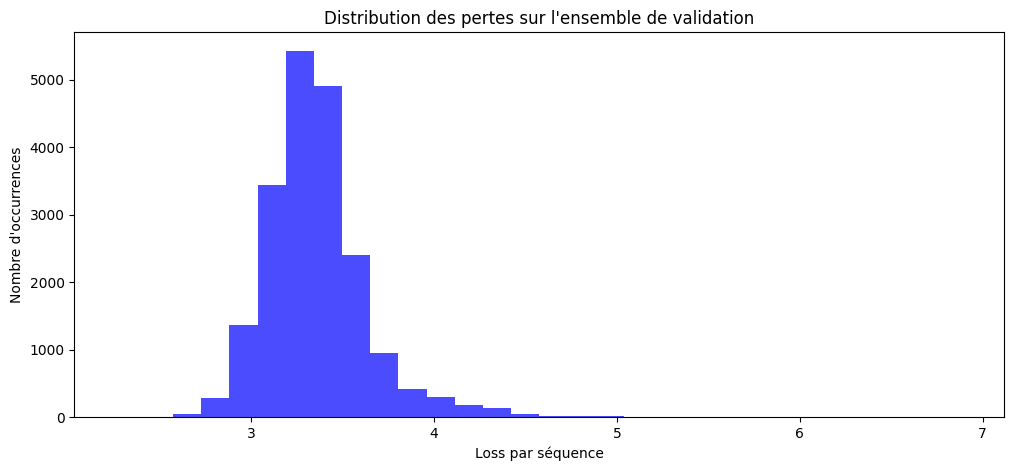

In [2]:
# Evaluation du modele

# Charger le modèle entraîné
if path.exists("/kaggle/working/password_lstm_attention.pt"):
    decoder = torch.load("/kaggle/working/password_lstm_attention.pt").to(device)
    decoder.eval()  # Mettre le modèle en mode évaluation
    print("✅ Modèle chargé avec succès !")
else:
    print("❌ Erreur : modèle introuvable.")
    exit()

# Charger les données de validation
try:
    val_file = unidecode(open("/kaggle/input/validation2/validation2.txt").read())
    val_file_len = len(val_file)
except FileNotFoundError:
    print("❌ Erreur : Le fichier validation2.txt est introuvable.")
    exit()

# Fonction pour obtenir un batch de validation
def validation_set():
    start_index = random.randint(0, val_file_len - chunk_len - 1)
    end_index = start_index + chunk_len + 1
    chunk = val_file[start_index:end_index]
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Fonction d'évaluation
def evaluate_model(num_samples=500):
    total_loss = 0
    correct = 0
    total = 0
    all_losses = []

    

    with torch.no_grad():  # Désactiver le calcul des gradients
        for _ in range(num_samples):  # Tester sur plusieurs échantillons
            inp, target = validation_set()
            hidden = decoder.init_hidden()
            loss = 0
            seq_len = inp.size(0)

            for c in range(seq_len):
                output, hidden = decoder(inp[c].unsqueeze(0), hidden)
                loss += criterion(output, target[c].unsqueeze(0))

                # Calcul de l'accuracy
                pred = output.argmax(dim=1)  # Trouver l'indice de la meilleure prédiction
                correct += (pred == target[c]).sum().item()
                total += 1

            loss = loss.item() / seq_len
            total_loss += loss
            all_losses.append(loss)

    avg_loss = total_loss / num_samples  # Moyenne des pertes
    accuracy = correct / val_file_len * 100  # Précision en %

    return avg_loss, accuracy, all_losses

# Exécuter l'évaluation
val_loss, val_accuracy, all_losses = evaluate_model(num_samples=20000)

print(f"\n📊 Résultats de la validation sur 100000 échantillons :")
print(f"   - Validation Loss : {val_loss:.4f}")
print(f"   - Validation Accuracy : {val_accuracy:.2f}%")

# Affichage des résultats sous forme graphique
plt.figure(figsize=(12, 5))

# Graphique de la distribution des pertes
plt.hist(all_losses, bins=30, color="blue", alpha=0.7)
plt.xlabel("Loss par séquence")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution des pertes sur l'ensemble de validation")
plt.show()

In [ ]:
import os
import torch
import random
import matplotlib.pyplot as plt
from unidecode import unidecode
from os import path
import string

# Activer le mode de débogage CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# === PARAMÈTRES À AJUSTER SELON TON CODE === #
chunk_len = 12  # longueur du mot de passe généré
all_characters = string.ascii_letters + string.digits + string.punctuation + " "
n_characters = len(all_characters)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fonction améliorée pour convertir un texte en tensor avec vérification explicite
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        if string[c] in all_characters:
            tensor[c] = all_characters.index(string[c])
        else:
            raise ValueError(f"Caractère inconnu détecté : '{string[c]}' à la position {c}")
    return tensor.to(device)

# Charger le modèle entraîné
if path.exists("/kaggle/working/password_lstm_attention.pt"):
    decoder = torch.load("/kaggle/working/password_lstm_attention.pt", map_location=device)
    decoder.eval()
    print("✅ Modèle chargé avec succès !")
else:
    print("❌ Erreur : modèle introuvable.")
    exit()

# Charger les données de validation
try:
    val_file = unidecode(open("/kaggle/input/validation2/validation2.txt").read())
    val_file_len = len(val_file)
except FileNotFoundError:
    print("❌ Erreur : Le fichier validation2.txt est introuvable.")
    exit()

# Identifier les caractères manquants
chars_dataset = set(val_file)
chars_manquants = chars_dataset - set(all_characters)

if chars_manquants:
    print("⚠️ Caractères manquants détectés dans ton jeu de données :")
    print(chars_manquants)

    # Ajouter automatiquement les caractères manquants
    all_characters += ''.join(sorted(chars_manquants))
    n_characters = len(all_characters)
    print("✅ Alphabet mis à jour :", all_characters)
else:
    print("✅ Aucun caractère manquant.")

# Fonction pour obtenir un batch de validation
def validation_set():
    start_index = random.randint(0, val_file_len - chunk_len - 1)
    end_index = start_index + chunk_len + 1
    chunk = val_file[start_index:end_index]
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Fonction d'évaluation complète avec vérifications intégrées
def evaluate_model(num_samples=500):
    total_loss = 0
    correct = 0
    total = 0
    all_losses = []
    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for sample_idx in range(1, num_samples + 1):
            inp, target = validation_set()
            hidden = decoder.init_hidden()
            loss = 0
            seq_len = inp.size(0)
            generated_password = ""

            for c in range(seq_len):
                output, hidden = decoder(inp[c].unsqueeze(0), hidden)
                loss += criterion(output, target[c].unsqueeze(0))

                pred_idx = output.argmax(dim=1).item()
                generated_password += all_characters[pred_idx]

                correct += (pred_idx == target[c].item())
                total += 1

            loss = loss.item() / seq_len
            total_loss += loss
            all_losses.append(loss)

            # Afficher le mot de passe généré pour cet échantillon
            print(f"🔑 Échantillon {sample_idx}/{num_samples} : {generated_password} (loss : {loss:.4f})")

    avg_loss = total_loss / num_samples
    accuracy = correct / total * 100

    return avg_loss, accuracy, all_losses

# Exécuter l'évaluation
val_loss, val_accuracy, all_losses = evaluate_model(num_samples=2000)

# Affichage résumé
print(f"\n📊 Résultats globaux sur l'ensemble de validation :")
print(f"   - Validation Loss : {val_loss:.4f}")
print(f"   - Validation Accuracy : {val_accuracy:.2f}%")

# Graphique de distribution des pertes
plt.figure(figsize=(12, 5))
plt.hist(all_losses, bins=30, color="blue", alpha=0.7)
plt.xlabel("Loss par séquence")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution des pertes sur l'ensemble de validation")
plt.show()


In [ ]:
!pip install unidecode

import unidecode
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import time, math
import matplotlib.pyplot as plt
from os import path, makedirs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_characters = string.ascii_letters + string.digits + string.punctuation
end_char = '&'
selected = string.ascii_letters + string.digits + end_char
n_characters = len(all_characters)
n_characters_selected = len(selected)

chunk_len = 12

hidden_size = 256
n_layers = 2
lr = 0.005
n_epochs = 3000


train_file = unidecode.unidecode(open("sample_data/train2_with_&.txt").read())
train_file_len = len(train_file)
val_file = unidecode.unidecode(open("sample_data/validation2.txt").read())
val_file_len = len(val_file)

def random_chunk(file, file_len):
  start_index = random.randint(0, file_len - chunk_len - 1)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]

def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
    if string[c] not in selected:
      continue
    tensor[c] = selected.index(string[c])
  return tensor.to(device)

def random_training_set(file, file_len):
  chunk = random_chunk(file, file_len)
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.n_layers = n_layers

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size, device=device)


def train(inp, target):
  hidden = decoder.init_hidden()
  decoder.zero_grad()
  loss = 0
  seq_len = inp.size(0) # Récupérer la longueur du batch actuel
  for c in range(seq_len):
    output, hidden = decoder(inp[c], hidden)
    loss += criterion(output, target[c].unsqueeze(0))
  loss.backward()
  optimizer.step()
  train_losses.append(loss.item() / seq_len)
  return loss.item() / seq_len


def evaluate(prime_str='A', predict_len=25, temperature=0.8):
  if predict_len is None:
    predict_len = random.randint(5, 12)

  hidden = decoder.init_hidden()
  prime_input = char_tensor(prime_str)
  predicted = prime_str

  for p in range(len(prime_str) - 1):
    _, hidden = decoder(prime_input[p], hidden)
  inp = prime_input[-1]

  for _ in range(predict_len):
    output, hidden = decoder(inp, hidden)
    output_dist = torch.softmax(output.data.view(-1) / temperature, dim=0)
    top_i = torch.multinomial(output_dist[:len(selected)], 1)[0]
    predicted_char = selected[top_i]

    if predicted_char == '&':
      break

    predicted += predicted_char
    inp = torch.tensor([selected.index(predicted_char)]).to(device)

  return predicted


def time_since(since):
  s = time.time() - since
  m = math.floor(s / 60)
  s -= m * 60
  return '%dm %ds' % (m, s)

def exponential_moving_average(values, alpha=0.01):
  ema = []
  avg = values[0] # Initialisation
  for value in values:
    avg = alpha * value + (1 - alpha) * avg
    ema.append(avg)
  return ema

def evaluate_loss(n_samples=1000):
  total_loss = 0
  for _ in range(n_samples):
    inp, target = random_training_set(val_file, val_file_len)
    hidden = decoder.init_hidden()
    loss = 0
  for c in range(inp.size(0)):
    output, hidden = decoder(inp[c], hidden)
  loss += criterion(output, target[c].unsqueeze(0))
  total_loss += loss.item() / inp.size(0)
  return total_loss / n_samples

decoder = RNN(n_characters, hidden_size, n_characters, n_layers).to(device)
optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses = []
eval_losses = []
print("Entraînement sur le dataset de mots de passe...")

start = time.time()
for epoch in range(1, n_epochs + 1):
  loss = train(*random_training_set(train_file, train_file_len))
  with torch.no_grad():
    eval_loss = evaluate_loss(n_samples=50)
    eval_losses.append(eval_loss)
  if epoch % 1000 == 0:
    print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

smoothed_train_losses = exponential_moving_average(train_losses, alpha=0.01)
smoothed_eval_losses = exponential_moving_average(eval_losses, alpha=0.01)

plt.plot(smoothed_train_losses, label='Loss lissée (EMA)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de la perte pendant l\'entraînement (lissée)')
plt.legend()
plt.show()

plt.plot(smoothed_eval_losses, label='Loss de validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de la perte de validation')
plt.legend()
plt.show()

# save

if not path.exists("models"):
  makedirs("models")
torch.save(decoder, f"models/password_rnn_{int(time.time())}.pt")

print("nGénération de mots de passe après entraînement :n")
for _ in range(10):
  print(evaluate(prime_str=random.choice(selected), temperature=0.7))